# EPA1361 - Model-Based Decision Making
# Week 3 - Sensitivity analysis

This exercise uses the same predator-prey model we used for the multi-model exercise, focusing on the Python version. As with the other exercise, define a model object for the function below, with the uncertainty ranges provided:

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |

* Sensitivity analysis often focuses on the final values of an outcome at the end of the simulation. However, we can also look at metrics that give us additional information about the behavior of the model over time. Using [the statsmodel library](https://www.statsmodels.org/stable/index.html) and an appropriate sampling design, fit a linear regression model for each of the following indicators. What can we conclude about the behavior of the model, and about the importance of the different inputs?

  * The final values of the _prey_ outcome
  * The mean values of the _prey_ outcome over time, within each experiment
  * The standard deviations of the _prey_ outcome over time, within each experiment
  

* Use the Sobol sampling functionality included in the Workbench to perform experiments with a sample size of N=50, then analyze the results with SALib for the same three indicators. This requires specifying the keyword argument `'uncertainty_sampling'` of perform_experiments. Note that when using Sobol sampling, the meaning of the keyword argument `scenarios` changes a bit. In order to properly estimate Sobol scores as well as interaction effects, you require N * (2D+2) scenarios, where D is the number of uncertain parameters, and N is the value for scenarios passed to `perform_experiments`. Repeat the analysis for larger sample sizes, with N=250 and N=1000. How can we interpret the first-order and total indices? Are these sample sizes sufficient for a stable estimation of the indices? You'll need to use the [get_SALib_problem](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/salib_samplers.html) function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function. 

* *hint*: sobol is a deterministic sequence of quasi random numbers. Thus, you can run with N=1000 and simply slice for 1:50 and 1:250.

* Use the [Extra-Trees analysis](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) included in the Workbench to approximate the Sobol total indices, with a suitable sampling design. As a starting point, use an ensemble of 100 trees and a max_features parameter of 0.6, and set the analysis to regression mode. Are the estimated importances stable relative to the sample size and the analysis parameters? How do the results compare to the Sobol indices? For more details on this analysis see [Jaxa-Rozen & Kwakkel (2018)](https://www.sciencedirect.com/science/article/pii/S1364815217311581)

### Start of assignment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging, MultiprocessingEvaluator)

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol
import pandas as pd
import seaborn as sns

### Python Model Creation

In [2]:
import sys  
sys.path.insert(0, './model/')
import PredPrey as PP

uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                 RealParameter('predation_rate', 0.0005, 0.003),
                 RealParameter('predator_efficiency', 0.001, 0.004),
                 RealParameter('predator_loss_rate', 0.04, 0.08)] 

outcomes = [TimeSeriesOutcome('TIME', function=np.squeeze),
            TimeSeriesOutcome('predators', function=np.squeeze),
            TimeSeriesOutcome('prey', function=np.squeeze)]

#Define the Python model
py_model = Model('Python', function=PP.PredPrey)
py_model.uncertainties = uncertainties
py_model.outcomes = outcomes

In [3]:
processes = 10

In [4]:
%%html
<link rel="stylesheet" href="style/style.css">

# Linear regression on Prey
The sampling technique chosen for this part is Latin Hypercube Sampling as recommended in the course materials. This method of sampling makes sure that there are no points of the analysis that are not "investigated". 

In [5]:
with MultiprocessingEvaluator(py_model, n_processes=processes) as evaluator:
    experiments, outcomes = perform_experiments(py_model, 50, uncertainty_sampling=LHS)

## Look at final values of prey
The final values of prey are shown in the figure below. 

In [6]:
prey = pd.DataFrame(outcomes["prey"]).T
preyfinal = pd.DataFrame(prey.iloc[-1])

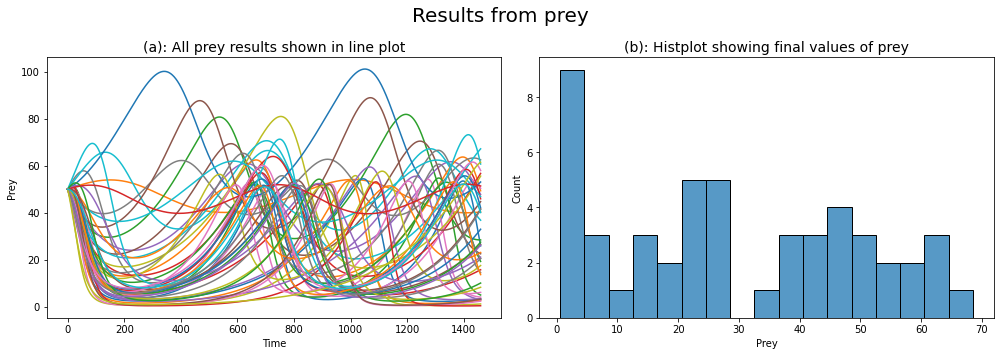

In [7]:
fig, ax = plt.subplots(figsize=(20,15), ncols=2)
prey.plot(legend=None, figsize=(14,5), ax = ax[0])
sns.histplot(data=preyfinal, ax=ax[1], legend=None, binwidth=4)
fig.suptitle('Results from prey', fontsize=20)
ax[0].set_title('(a): All prey results shown in line plot', fontsize=14)
ax[1].set_title('(b): Histplot showing final values of prey', fontsize=14)
ax[1].set_xlabel('Prey')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Prey')
fig.tight_layout()
plt.show()

<h1 class="analysis">Analysis</h1>
<div class="analysis"> 
 Figure (a) shows an overview of all the different model runs. Visual analysis shows that the number of 'large' outliers is around 9. At least the runs, where the model differst more from the rest of the model behaviour. 
- Figre (b) shows the final values of the prey model. Some gaps can be identified there, which means that certain scores of prey are not in the final values. 
</div>


## *Final results* - regression

In [8]:
X = experiments[["predation_rate", "predator_efficiency", "predator_loss_rate", "prey_birth_rate"]]
X = sm.add_constant(X)
Y = preyfinal

In [9]:
# do the regression
mod_fv = sm.OLS(Y, X).fit()

In [10]:
#results of the regression
mod_fv.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   1460   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     9.434
Date:                Wed, 12 May 2021   Prob (F-statistic):           1.26e-05
Time:                        19:46:13   Log-Likelihood:                -205.69
No. Observations:                  50   AIC:                             421.4
Df Residuals:                      45   BIC:                             430.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  55.4924     19.683      2.819      0.007      15.849      95.136
predation_rate       2948.6263   3091.989      0.954      0.345   -3278.960    9176.213
predator_efficiency -1.471e+04   2565.304     -5.733      0.000   -1.99e+04   -9540.244
predator_loss_rate    190.2082    197.229      0.964      0.340    -207.031     587.448
prey_birth_rate      -240.9259    394.213     -0.611      0.544   -1034.912     553.060
==============================================================================
Omnibus:                        1.479   Durbin-Watson:                   1.649
Prob(Omnibus):                  0.477   Jarque-Bera (JB):                1.475
Skew:                           0.358   Prob(JB):                        0.478
Kurtosis:                       2.559   Cond. No.                     1.41e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

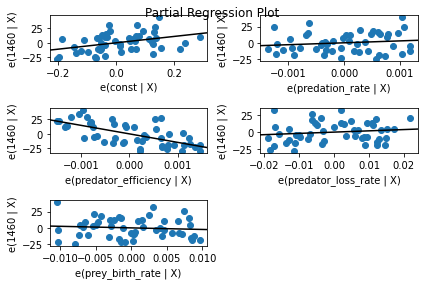

In [37]:
sm.graphics.plot_partregress_grid(mod_fv)
fig.tight_layout(pad=1.0)

<h1 class="analysis">Analysis</h1>
<div class="analysis"> 
    The results mention that the condition number is large. Which might indicate that there is a multicollinearity or other numerical problems.This is seen in the figure above, between e(predation_rate|x) and e(predator_loss_rate|x). <br>
    <br>
The coefficients show that <i>predator loss rate</i> has the most influence on the prey-variable. The P-value indicates that we can reject the null-hypothesis. Note that the margin of error for <i>predation rate</i> and <i>predator efficiency</i> is extremely high.
</div>

## *Mean values* - regression

In [12]:
Y = [i.mean() for i in outcomes["prey"]]

In [13]:
mod_mean = sm.OLS(Y, X).fit()

In [14]:
mod_mean.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     99.48
Date:                Wed, 12 May 2021   Prob (F-statistic):           9.59e-22
Time:                        19:46:14   Log-Likelihood:                -143.39
No. Observations:                  50   AIC:                             296.8
Df Residuals:                      45   BIC:                             306.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  32.5122      5.662      5.742      0.000      21.108      43.916
predation_rate      -1702.2293    889.438     -1.914      0.062   -3493.649      89.190
predator_efficiency -1.291e+04    737.932    -17.489      0.000   -1.44e+04   -1.14e+04
predator_loss_rate    473.7760     56.735      8.351      0.000     359.507     588.045
prey_birth_rate        52.4310    113.399      0.462      0.646    -175.966     280.828
==============================================================================
Omnibus:                       20.186   Durbin-Watson:                   1.722
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.018
Skew:                           1.357   Prob(JB):                     5.00e-07
Kurtosis:                       5.562   Cond. No.                     1.41e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

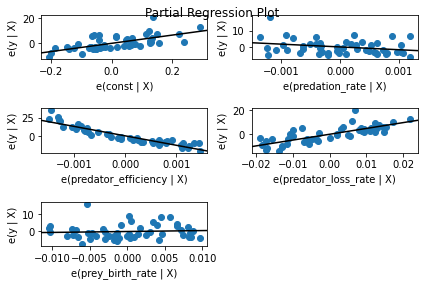

In [42]:
sm.graphics.plot_partregress_grid(mod_mean)
fig.tight_layout(pad=1.0)

<h1 class="analysis">Analysis</h1>
<div class="analysis"> 
    The results mention that the condition number is large. Which might indicate that there is a multicollinearity or other numerical problems.This is seen in the figure above, between e(const|x) and e(predator_loss_rate|x). <br>
    <br>
The coefficients show that <i>predator loss rate</i> has the most influence on the prey-variable. The P-value indicates that we can reject the null-hypothesis. Note that the margin of error for <i>predation rate</i> and <i>predator efficiency</i> is extremely high.
</div>
</div>

## Standard deviations

In [16]:
Y = outcomes["prey"].std(axis=1)

In [17]:
mod_std = sm.OLS(Y, X).fit()

In [39]:
mod_std.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     2.344
Date:                Wed, 12 May 2021   Prob (F-statistic):             0.0690
Time:                        20:28:58   Log-Likelihood:                -122.96
No. Observations:                  50   AIC:                             255.9
Df Residuals:                      45   BIC:                             265.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  12.4455      3.763      3.308      0.002       4.867      20.024
predation_rate       1161.2119    591.056      1.965      0.056     -29.235    2351.659
predator_efficiency   306.6484    490.376      0.625      0.535    -681.020    1294.316
predator_loss_rate    -49.7915     37.702     -1.321      0.193    -125.727      26.144
prey_birth_rate       107.9152     75.357      1.432      0.159     -43.861     259.691
==============================================================================
Omnibus:                        5.279   Durbin-Watson:                   2.340
Prob(Omnibus):                  0.071   Jarque-Bera (JB):                6.280
Skew:                          -0.215   Prob(JB):                       0.0433
Kurtosis:                       4.682   Cond. No.                     1.41e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

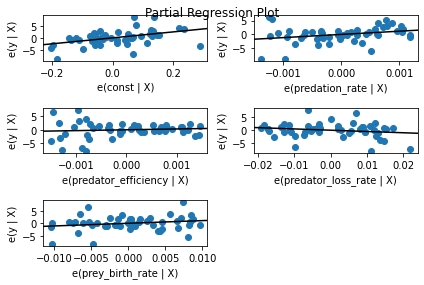

In [41]:
sm.graphics.plot_partregress_grid(mod_std)
fig.tight_layout(pad=1.0)

<h1 class="analysis">Analysis</h1>
<div class="analysis"> 
    The results mention that the condition number is large. Which might indicate that there is a multicollinearity or other numerical problems.This is seen in the figure above, between e(predation_rate|x) and e(predator_efficiency|x). <br>
    <br>
The coefficients show that <i>predator loss rate</i> has the most influence on the prey-variable. The P-value indicates that we can reject the null-hypothesis. Note that the margin of error for <i>predation rate</i> and <i>predator efficiency</i> is extremely high.
</div>
</div>

### Comparison of the coefficients
The following part is used to analysise the coefficients. 

In [19]:
params = pd.DataFrame(mod_fv.params, columns=["final"])
params["means"] = mod_mean.params
params["std"] = mod_std.params
params.drop(index="const", inplace=True)

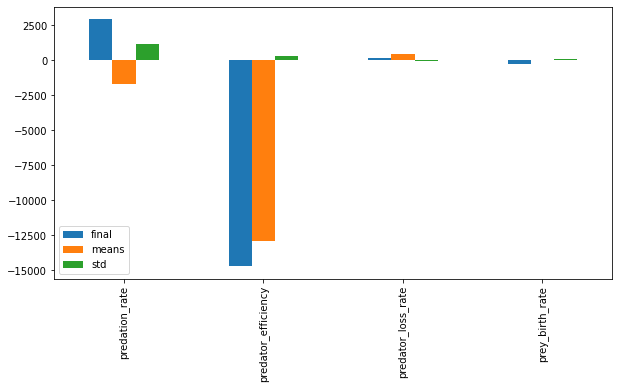

In [20]:
fig, ax = plt.subplots(figsize=(10,5))
params.plot.bar(ax=ax)
plt.show()

### Comparison of rsquared

In [45]:
print(mod_fv.rsquared_adj)
print(mod_mean.rsquared_adj)
print(mod_std.rsquared_adj)

0.40775277133555987
0.8893695944434443
0.09888958526775737


<h1 class="analysis">Analysis</h1>
<div class="analysis"> 
    The results mention that the condition number is large. Which might indicate that there is a multicollinearity or other numerical problems.This is seen in the figure above, between e(predation_rate|x) and e(predator_efficiency|x).
    <br>
    <br>
The coefficients show that <i>predator loss rate</i> has the most influence on the prey-variable. The P-value indicates that we can reject the null-hypothesis. Note that the margin of error for <i>predation rate</i> and <i>predator efficiency</i> is extremely high.
</div>
</div>

# Sobol
---
Start of the Sobol analysis

In [46]:
with MultiprocessingEvaluator(py_model, n_processes=processes) as evaluator:
    sa_experiments, sa_outcomes = perform_experiments(py_model, scenarios=50 * (2 * 4 + 2), uncertainty_sampling=SOBOL)

C:\Users\joren\anaconda3\envs\MBDM\lib\site-packages\SALib\sample\saltelli.py:52: FutureWarning: 
        Convergence properties of the Sobol' sequence is only valid if `N` = 2^n.
        SALib will continue on, but results may have issues.
        In future, this will raise an error.
        
  warnings.warn(msg, FutureWarning)


In [47]:
problem = get_SALib_problem(py_model.uncertainties)
Si = sobol.analyze(problem, sa_outcomes['prey'].ravel(), calc_second_order=True, print_to_console=False)

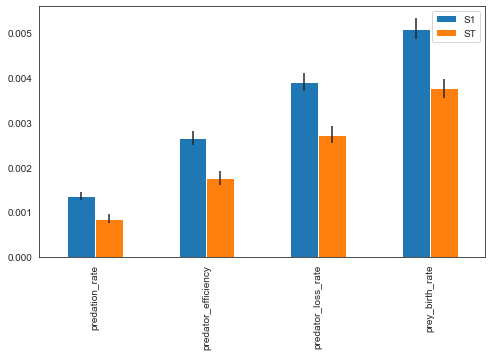

In [48]:
scores_filtered = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(scores_filtered, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

<h1 class="analysis">Analysis</h1>
<div class="analysis"> 
    The results mention that the condition number is large. Which might indicate that there is a multicollinearity or other numerical problems.This is seen in the figure above, between e(predation_rate|x) and e(predator_efficiency|x).
    <br>
    <br>
The coefficients show that <i>predator loss rate</i> has the most influence on the prey-variable. The P-value indicates that we can reject the null-hypothesis. Note that the margin of error for <i>predation rate</i> and <i>predator efficiency</i> is extremely high.
</div>
</div>

## Extra-trees analysis
---
Now continue with the extra-trees analysis

In [49]:
sobol_mean = pd.Series([i.mean() for i in sa_outcomes["prey"]]).astype('int')

In [50]:
sobol_std = pd.Series(sa_outcomes["prey"].std(axis=1)).astype('int')

In [51]:
sobol_final = pd.DataFrame(sa_outcomes["prey"]).T.iloc[-1]

In [52]:
scores = []
for y in [sobol_mean, sobol_std, sobol_final]:
    scores.append(feature_scoring.get_ex_feature_scores(sa_experiments, y, mode=RuleInductionType.REGRESSION, nr_trees=100, max_features=0.6)[0])

In [53]:
scores

[                            1
 0                            
 predator_efficiency  0.776737
 predator_loss_rate   0.201439
 prey_birth_rate      0.011753
 predation_rate       0.010071,
                             1
 0                            
 predation_rate       0.390294
 predator_efficiency  0.326187
 prey_birth_rate      0.161204
 predator_loss_rate   0.122315,
                             1
 0                            
 predator_efficiency  0.500484
 predator_loss_rate   0.226497
 prey_birth_rate      0.206211
 predation_rate       0.066809]

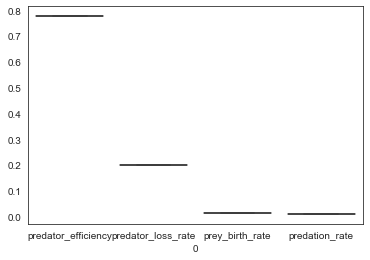

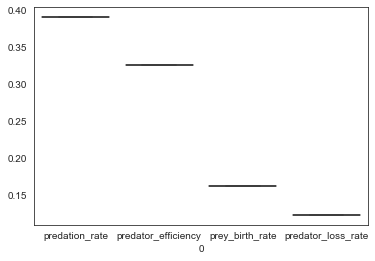

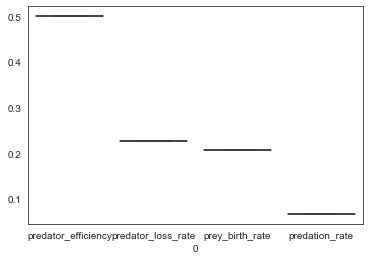

In [54]:
for i in scores:
    sns.boxplot(data=i.T)
    plt.show()

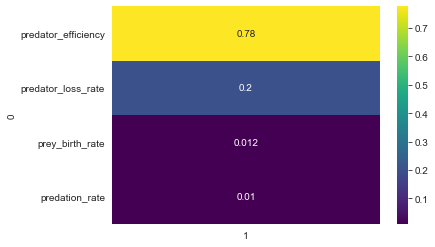

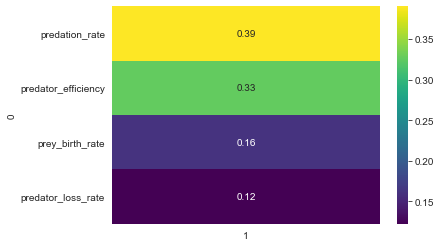

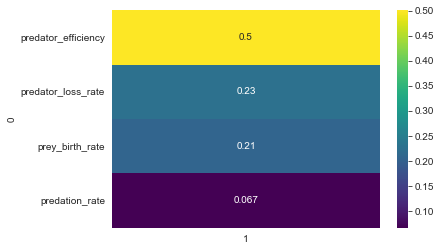

In [55]:
for i in scores:
    sns.heatmap(i, annot=True, cmap='viridis')
    plt.show()

In [56]:
scores

[                            1
 0                            
 predator_efficiency  0.776737
 predator_loss_rate   0.201439
 prey_birth_rate      0.011753
 predation_rate       0.010071,
                             1
 0                            
 predation_rate       0.390294
 predator_efficiency  0.326187
 prey_birth_rate      0.161204
 predator_loss_rate   0.122315,
                             1
 0                            
 predator_efficiency  0.500484
 predator_loss_rate   0.226497
 prey_birth_rate      0.206211
 predation_rate       0.066809]

In [57]:
scores_df = pd.concat(scores, axis=1, sort=False)

In [58]:
scores_list = scores_df.to_numpy()

In [59]:
scores_list

array([[0.77673671, 0.32618733, 0.50048363],
       [0.20143947, 0.1223146 , 0.22649678],
       [0.01175292, 0.16120377, 0.20621094],
       [0.01007089, 0.3902943 , 0.06680865]])

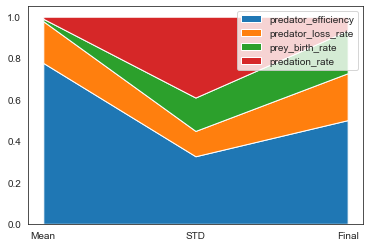

In [60]:
fig, ax = plt.subplots()
ax.stackplot(range(scores_list.shape[1]), scores_list, labels=scores[0].index.values)
plt.legend()
ax.set_xticks(range(3)) # <--- set the ticks first
ax.set_xticklabels(["Mean", "STD", "Final"])
plt.show()